## MD simulations of fluids

In [2]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

### Initial positions, velocities and forces

Unlike MC simulation where the initial condition is fully specified by positin arrray in MD simulations we must also specify initial velocities which allows us to determine initial forces!

In [17]:
def IC_pos(rho=0.88, N_cell=3):
    """
    Create a lattice of Lennard-Jones particles initially placed in a cubic FCC lattice.

    Parameters:
    rho (float, optional): Number density of particles. Defaults to 0.88.
    N_cell (int, optional): Number of unit cells in one direction. Defaults to 3.

    Returns:
    np.array: Array of particle positions.
    float: Length of the simulation box.
    int: Total number of particles.
    """
    from itertools import product
    
    N = 4 * N_cell ** 3  # Total number of particles in the system
    L = (N / rho) ** (1 / 3)  # Length of the simulation box
    L_cell = L / N_cell  # Length of a unit cell

    # Generate positions within the unit cell
    base_positions = np.array([[0, 0, 0],
                               [0, 0.5, 0.5],
                               [0.5, 0, 0.5],
                               [0.5, 0.5, 0]])

    # Create lattice by translating the base positions
    pos = np.array([base + np.array([x, y, z]) for x, y, z in product(range(N_cell), repeat=3)
                    for base in base_positions])

    # Scale positions to the size of the unit cell
    pos *= L_cell

    return pos, L, N


def IC_vel(N):
    '''Genreate initial distribution of velocities from Maxwell-Botlzmann'''

    vel  = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)

    return vel 

def IC_F(N):
    '''Generate force matrix objects to be used throughout simulation
    ---
    F:  (N, N, 3) array that contains all the forces between i, j particles in 3D
    ind: arrays of size N and N. These are indices of upper triangular matrix e.g (i, j) such that  i<j. 
    Having indices of all inter-particle forces allows us to avoid using for loops

    '''
    
    F   = np.zeros((N, N, 3))       
    I, J = np.triu_indices(N, k=1)   
    
    return F, I, J

### Inspect initial positions, forces and velocities

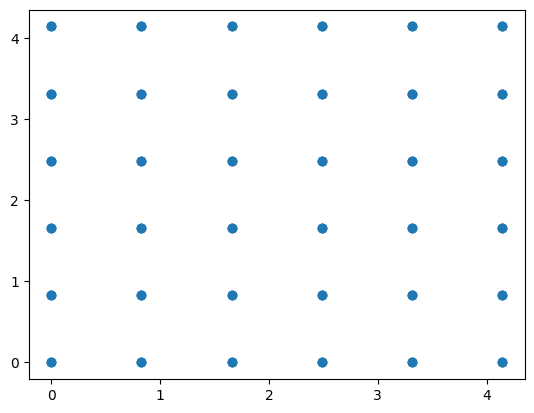

In [19]:
pos, L_box, N = IC_pos(rho=0.88, N_cell=3)

plt.scatter(pos[:, 0], pos[:,1])

In [20]:
F, I, J = IC_F(5)

print(F.shape)
print(I)
print(J)

(5, 5, 3)
[0 0 0 0 1 1 1 2 2 3]
[1 2 3 4 2 3 4 3 4 4]


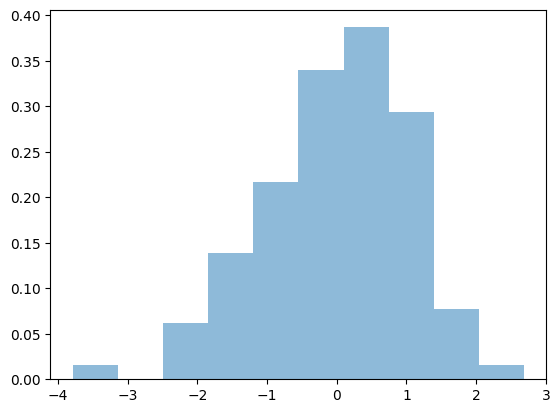

In [21]:
vel = IC_vel(100)

plt.hist(vel[:,0], alpha=0.5, density=True);

### Computation of forces

- Most of the computational heavy lifting in MD simulations goes into evaluation of forces. 

- As the number of particles goes so does the need to evaluate the number of interacting pairs

- In realistic simulations neighbor lists and cutoff distances are used to minimize and keep track of smaller number of particle pairs

In [22]:
def force_update(pos):   
    '''This function is used to update the force matrix F which has been created via IC_F function earlier
    pos: (N, 3) position array is specified as input
    
    returns
    ---
    forces:
    U:    potential energy
    P:    pressure
    hist: histogram of r^2 distances
    '''

    # Compute all unique ij distances
    r_vec = pos[I] - pos[J]

    # Use min image criteria for distances
    r_vec = (r_vec + L_box/2) % L_box - L_box/2

    # Compute r^2
    r_sq = np.sum(r_vec**2, axis=1)

    # Compute forces 
    dUdr = -(48 / r_sq ** 7 - 24 / r_sq ** 4)

    # Compute force maxtirx containing all forces between ij particles dU/dr * dr
    F[I,J] = dUdr[:, np.newaxis] * r_vec

    # Compute total force acting on each particle (i=1,...N) 
    forces = F.sum(axis=0) - F.sum(axis=1)

    # Compute potential energy, pressure and histogram of r^2 pair distances
    U = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)

    P = np.sum(F[I,J] * r_vec)

    hist = np.histogram(r_sq, bins=30, range=(0, L_box / 2))[0]
    
    return forces, U, P, hist

### Time stepping 

In [30]:
def time_step(pos, vel, F, dt=0.01):
    '''Update velocities, positions and forces after dt time step of integration'''

    vel += 0.5 * F * dt
    
    pos = np.mod(pos + vel * dt, L_box)

    F, pot, P, hist = force_update(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)

    return pos, vel, F, pot, kin, P, hist

### MD simulation loop

In [27]:
def simulate(pos, 
             vel, 
             T=1, 
             freq_out=50, 
             nsteps=10000):
    '''Main MD simulation loop. All of the variables and force matrix must be initialized 
    so that functions can acess them'''

    kins, pots, Ps, hists = [], [], [], []
    
    F = force_update(pos)[0]

    for t in range(nsteps):

        # Update positions, velocities, forces
        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)

        # Scaling velocitites to keep T constant
        vel *= np.sqrt(N * 3 * T / (2 * kin))
        
        # Save thermo output
        if t % freq_out == 0:

            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)

    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0)

### Running MD simulation

- Note that variables pos, L_box, F, I, J, vel are global variables which are used and updated by simulate function. 
- Therefore we collect all the relevant parameters of simulation in once cell to make it easy to do various exploratons.

In [31]:
#------- Initalize global variables: positions, box length, velocities and Forces-------
pos, L_box, N  = IC_pos(rho=0.88, N_cell=3) 
vel            = IC_vel(N)
F, I, J        = IC_F(N)

#Run simulation
kins, pots, Ps, hist = simulate(pos, vel, T=1, freq_out=50, nsteps=10000)

### Analysis of MD simulation 

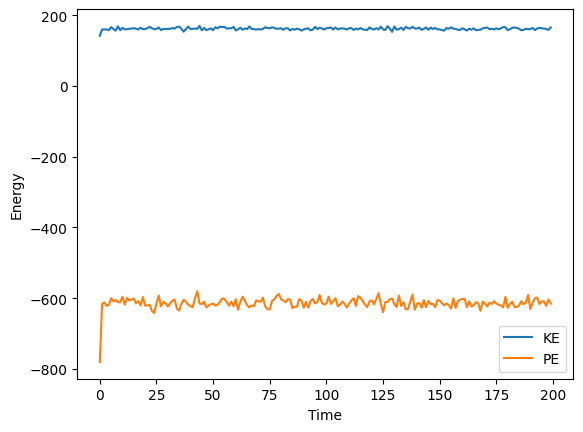

In [32]:
plt.plot(kins, label='KE')
plt.plot(pots, label='PE')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

/var/folders/3h/w4n54dz57dvbhgvz68gdv0f0f3hkmm/T/ipykernel_77253/971943631.py:3: RuntimeWarning: invalid value encountered in divide
  pair_correlation = hist / (4 * np.pi * rho * r)


Text(0, 0.5, '$g(r)$')

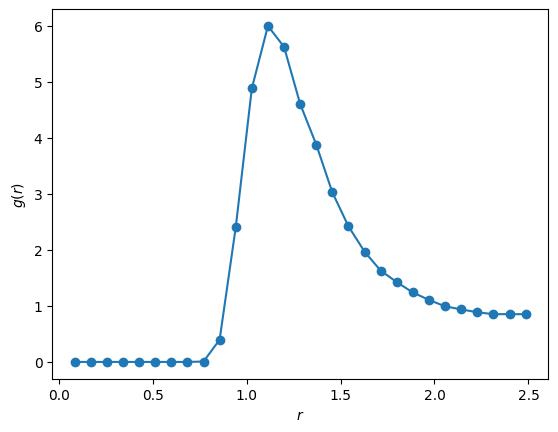

In [34]:
rho=0.88
r = np.linspace(0, L_box / 2, 30)
pair_correlation = hist / (4 * np.pi * rho * r)

plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')